# Image Segementation FCN

In [1]:
# DL framework
import tensorflow as tf

from datetime import datetime

# common packages
import numpy as np
import os # handling file i/o
import sys
import math
import time # timing epochs

# for ordered dict when building layer components
import collections

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar helper

# read image
from scipy.misc import imread
# + data augmentation
from scipy import ndimage
from scipy import misc

# used for manually saving best params
import pickle

# for shuffling data batches
from sklearn.utils import shuffle

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# helper to create dirs if they don't already exist
def maybe_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} createed".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
    
# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Important Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.4.0
Default GPU Device: /device:GPU:0


In [2]:
# `saver/` will hold tf saver files
maybe_create_dir("saver")
# `best_params/` will hold a serialized version of the best params
# I like to keep this as a backup in case I run into issues with
# the saver files
maybe_create_dir("best_params")
# `tf_logs/` will hold the logs that will be visable in tensorboard
maybe_create_dir("tf_logs")


saver already exists
best_params already exists
tf_logs already exists


In [3]:
# these two functions (get_model_params and restore_model_params) are 
# ad[a|o]pted from; 
# https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb
def get_model_params():
    global_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {global_vars.op.name: value for global_vars, value in 
            zip(global_vars, tf.get_default_session().run(global_vars))}

def restore_model_params(model_params, g, sess):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: g.get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    sess.run(assign_ops, feed_dict=feed_dict)

# these two functions are used to manually save the best
# model params to disk
def save_obj(obj, name):
    with open('best_params/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('best_params/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
# helper to add an image to the plot and choose whether
# to include the color bar
def implot(mp, ax, SHOW_CB=False):
    im = ax.imshow(mp)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    if SHOW_CB:
        cbar = plt.colorbar(im, cax=cax, format='%1.2f', boundaries=np.linspace(0,1,20))
    else:
        cax.set_axis_off()

    ax.set_axis_off()

def show_masked_result(image, mask):
    # create combined image of (image & mask)
    combined = np.copy(img)
    combined[mask == 0] = [0, 0, 0]

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))

    implot(image, ax1)
    implot(mask, ax2, True)
    implot(combined, ax3)

    plt.grid('off')
    plt.tight_layout()
    plt.show()

In [5]:
# image dimensions (GLOBAL) - [MG_WIDTH x IMG_HEIGHT, CHANNELS]
SQUARE_DIM = 224
if SQUARE_DIM:
    IMG_WIDTH = SQUARE_DIM
    IMG_HEIGHT = SQUARE_DIM
CHANNELS = 3
    
ROOT_DATA = "../ROOT_DATA/lesions/segmentation/"
    
# load entire dataset into memory
# NOTE: depending on your machine, this may not be practical, you may have to
# create a smaller dataset (although this should have already been noticed when
# making this dataset)
X_dev = np.load(ROOT_DATA + str(SQUARE_DIM) + "_" + str(SQUARE_DIM) +  '/images.npy')
y_dev = np.load(ROOT_DATA + str(SQUARE_DIM) + "_" + str(SQUARE_DIM) + '/masks.npy')

# test set supplied (doesn't need to come from training data)
X_test = np.load(ROOT_DATA + str(SQUARE_DIM) + "_" + str(SQUARE_DIM) +  '/test_images.npy')
y_test = np.load(ROOT_DATA + str(SQUARE_DIM) + "_" + str(SQUARE_DIM) + '/test_masks.npy')

# shuffle set -- not necessary, but I like to do this in case there
# is some order to the data we don't know about.  Not that important
# for this particular problem (segmentation), but I still feel better
# calling a shuffle before splitting the data
X_dev, y_dev = shuffle(X_dev, y_dev, random_state=42)

## Preprocessing
[preprocess_mask]: ./misc/segmentation_clipping_y.png
[preprocess_image]: ./misc/segmentation_preprocessing_x.png

### Masks
Our mask is currently in non-binary form.  The resize that was used created intermediate values {shown below}.  To address this, we need to clip the values to binary form.

![mask preprocessing][preprocess_mask]


### Input image
The image is currently in [0, 255], this is ok, but we're going to scale the input image to [0,1].  This will be done for each image.  This will be a simple/basic scaling, meaning we'll divide each image pixel (minus the image min) value by the (individual image's) max - min*.
TODO: explain and reference this process

![image preprocessing][preprocess_image]

*NOTE: this methodology may not be best for this and/or your independent problem.

In [6]:
# preprocess mask (example shown above)
# threshold (clip) to [0, 1] where 0:no mask, 1:mask
# convert to datatype int
y_dev = [np.clip(img, 0, 1).astype(np.int32) for img in y_dev]
y_dev = np.asarray(y_dev)

y_test = [np.clip(img, 0, 1).astype(np.int32) for img in y_test]
y_test = np.asarray(y_test)

In [7]:
# preprocess image (example shown above)
X_dev = [(image-np.amin(image))/(np.amax(image)-np.amin(image)) for image in X_dev]
X_dev = np.asarray(X_dev)

X_test = [(image-np.amin(image))/(np.amax(image)-np.amin(image)) for image in X_test]
X_test = np.asarray(X_test)

In [8]:
# view dataset information
print("Training :  X:{} , y:{}".format(X_dev.shape, y_dev.shape))
print("Test     :  X:{}  , y:{}".format(X_test.shape, y_test.shape))

Training :  X:(2000, 224, 224, 3) , y:(2000, 224, 224)
Test     :  X:(600, 224, 224, 3)  , y:(600, 224, 224)


In [9]:
# break into validation set
# note: this will be a ridgid split 
# (validation data will not be inluded in the trainin data)
# NOTE: this may/or may not how you wish to personally approach this
# break into dev / test

# here we'll use 10% for validation (90% training)
split_thresh = int(X_dev.shape[0] * 0.90)
X_train = X_dev[:split_thresh]
y_train = y_dev[:split_thresh]
X_val = X_dev[split_thresh:]
y_val = y_dev[split_thresh:]

print("Training   :  X:{} , y:{}".format(X_train.shape, y_train.shape))
print("Validation :  X:{}  , y:{}".format(X_val.shape, y_val.shape))
print("Test       :  X:{}  , y:{}".format(X_test.shape, y_test.shape))

Training   :  X:(1800, 224, 224, 3) , y:(1800, 224, 224)
Validation :  X:(200, 224, 224, 3)  , y:(200, 224, 224)
Test       :  X:(600, 224, 224, 3)  , y:(600, 224, 224)


### View examples from current dataset split

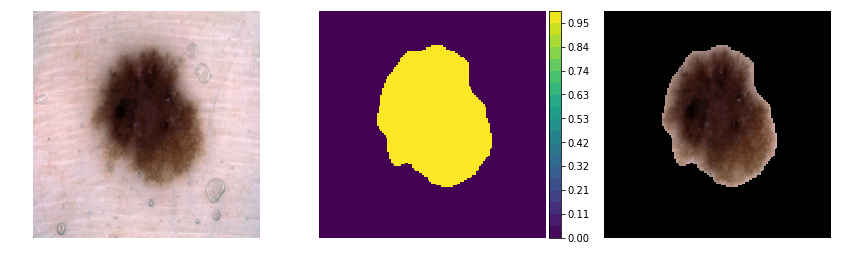

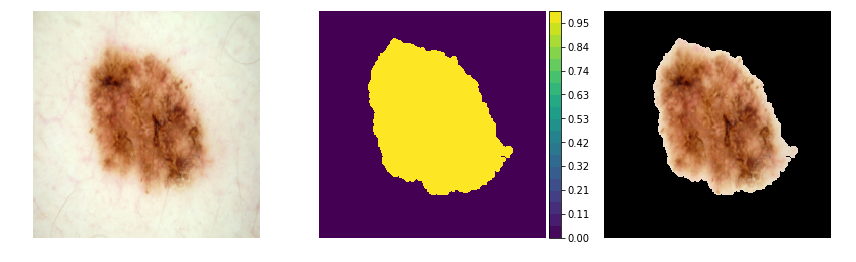

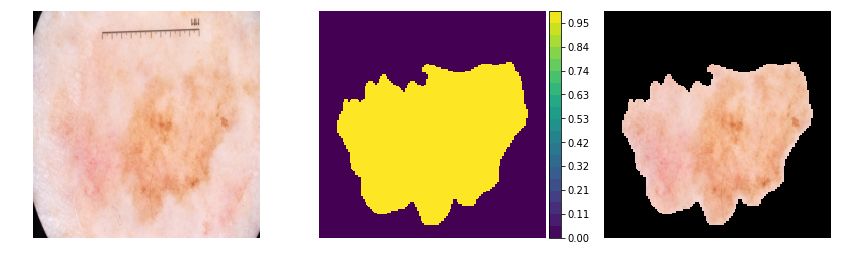

In [10]:
for i in range(3):
    img = X_train[i,:,:]
    mask = y_train[i,:,:]
    show_masked_result(img, mask)